In [1]:
%load_ext autoreload
%autoreload 2

import torch
import pyro
from pyro import distributions as dist
from pyro import poutine
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
#sns.set()

# Model

## Toy model

Input X - corresponds to any kind of phase space input - some **distribution** with prior.
Input $\mu$ - corresponds to parameters of surrogate, ie - size of detector, magnetic field, etc. - a **number**.

Define some functions f, g - those can be varied. Probably, bettern to stcik with some types of them, ie:
continous, pereodic, polynomial, ...

$$X \sim U(0,1), \ \ \mu \sim \delta(\mu - \mu_0) $$

$$latent\_x \sim  \mathcal{N} (latent\_x | X, 1)$$

$$laten\_mu \sim \mathcal{N}(laten\_mu |\mu, 1)$$

$$ f(\alpha) = a + b \alpha + sin(\alpha) $$
$$ g(\alpha) = a * \alpha $$

$$y \sim \mathcal{N}(y|f(latent_x), abs(g(latent_mu))$$

### Problem statement

1. Fit GAN/GP/NV to match p(y|X,mu)

2. Solve optimisaiton problem of the choise:
 - $argmin_{mu} (y - Y_0) ^2 2$
 - $argmax_{mu} p(y|mu) = \int p(y|X,mu) p(X) dx$
 - $etc$



## Make model with `pyro`

In [103]:
mu_dist = dist.Delta(torch.tensor(-50., requires_grad=True))
p_dist = dist.Exponential(rate=0.01)
theta_dist = dist.Uniform(0, 0.01)

In [81]:
sample = p_dist.sample([1000]) + 20
pt = 1 / sample * torch.sin(theta_dist.sample(sample.shape)) * 10000 # normalising kostyl

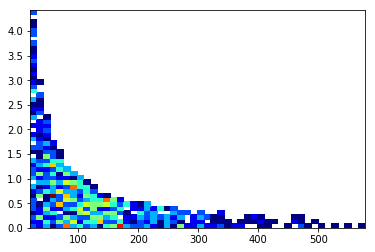

In [125]:
my_cmap = plt.cm.jet
my_cmap.set_under('white')
plt.hist2d(sample.numpy(), pt.numpy(), bins=50, cmap=my_cmap, cmin=0.0000001);

In [109]:
def y_sample(offset=20):
    mu = pyro.sample('mu', mu_dist)
    x = pyro.sample("x", dist.Normal(mu, 1))
    
    p = pyro.sample('p', p_dist) + offset
    theta = torch.sin(pyro.sample('theta', theta_dist))
    #pt = 1 / p * torch.sin(theta) * 10000
    
    theta_s = 1 / p
    y_var = theta_s * abs(x) ** 3 / 6
    y_mean = x ** 2 / p
    return pyro.sample("y", dist.Normal(y_mean, torch.sqrt(y_var)))

In [123]:
conditioned_y_sample = poutine.condition(y_sample, data={"mu": torch.tensor(24.)})

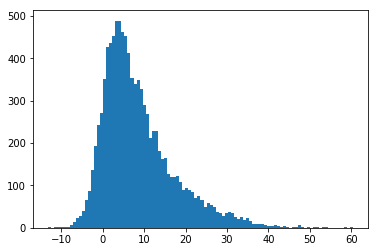

In [124]:
plt.hist([conditioned_y_sample().item() for _ in range(10000)], bins=100);

In [68]:
def f(x):
    return x.sin() + x.tanh()

#@pyro.condition(data={"x": torch.tensor(1.)})
def y_sample():
    mu = pyro.sample('mu', mu_dist)
    x = pyro.sample("x", dist.Normal(mu, 1))
    x = f(x)
    return pyro.sample("y", dist.Normal(x, 1))

## Statistic of interest

$$r = \frac{1}{N} \sum\limits_{i=0}^{N} || y_i - Y ||_2^2$$

In [4]:
def R(ys: torch.tensor, Y_0=-5):
    return (ys - Y_0).pow(2).mean()

## Approaches to solve the problem

### First one

  1. Make approximation of this model:

  $$p(y | \mu)$$

  With GANs or some other techniques.
  

  2. Sample $\{ y_i \}_{i=0}^{B} \sim p(y | \mu)$
  
  
  3. Calc $r = R(\{ y_i \}_{i=0}^{B})$
  
  
  4. Find $\frac{\partial r}{\partial \mu}$
  
### Second one


  1. Make approximation of this model:

  $$p(r | \mu)$$
  
  
  2. Sample $r \sim p(r | \mu)$
  
  
  3. Find $\frac{\partial r}{\partial \mu}$

## Investigation of the model

In [5]:
samples = torch.stack([y_sample() for _ in range(1000)])

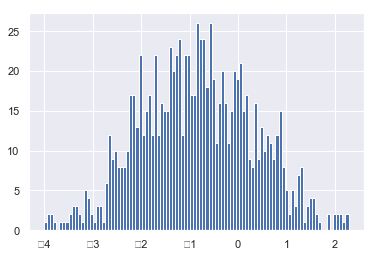

In [6]:
plt.hist(samples.detach().cpu().numpy(), bins=100);

In [7]:
R(samples).item()

18.617748260498047

#### Simple way to change `mu`

In [8]:
conditioned_y_sample = poutine.condition(y_sample, data={"mu": torch.tensor(-2.)})

In [9]:
samples = torch.stack([conditioned_y_sample() for _ in range(1000)])

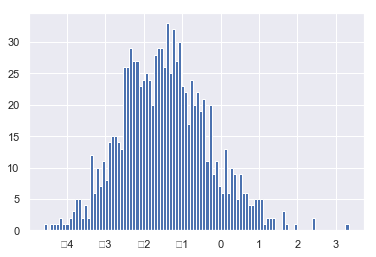

In [10]:
plt.hist(samples.detach().cpu().numpy(), bins=100);

In [11]:
import numpy as np

rs = []
mus = np.linspace(-100, 100, 100)
for mu in tqdm.tqdm(mus):
    conditioned_y_sample = poutine.condition(y_sample, data={"mu": torch.tensor(mu)})
    samples = torch.stack([conditioned_y_sample() for _ in range(1000)])
    rs.append(R(samples).item())

100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


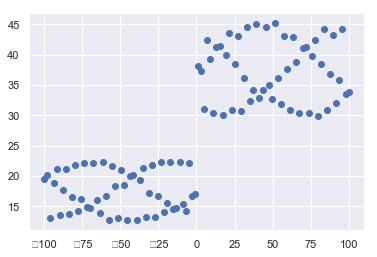

In [12]:
plt.scatter(mus, rs)